In [1]:
#installing patool for unzipping & split-folder for splitting the folder into train,test,val
!pip install patool
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 7.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import patoolib
import cv2
import glob
import os
import splitfolders as sf

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from keras.preprocessing.image import ImageDataGenerator

In [5]:
import pandas as pd
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt

In [6]:
#set the path where the zip files of images are present
input='/content/drive/MyDrive/CTscan/'

In [7]:
#unzipping folder containing CT scan images
patoolib.extract_archive(input+"COVID.zip",outdir='/content/CTscan')

patool: Extracting /content/drive/MyDrive/CTscan/COVID.zip ...
patool: running /usr/bin/7z x -o/content/CTscan -- /content/drive/MyDrive/CTscan/COVID.zip
patool: ... /content/drive/MyDrive/CTscan/COVID.zip extracted to `/content/CTscan'.


'/content/CTscan'

In [8]:
patoolib.extract_archive(input+"nonCOVID.zip",outdir='/content/CTscan')

patool: Extracting /content/drive/MyDrive/CTscan/nonCOVID.zip ...
patool: running /usr/bin/7z x -o/content/CTscan -- /content/drive/MyDrive/CTscan/nonCOVID.zip
patool: ... /content/drive/MyDrive/CTscan/nonCOVID.zip extracted to `/content/CTscan'.


'/content/CTscan'

In [9]:
curr=os.getcwd()

In [10]:
#Resizing images to 224x224 for Resnet
inputfolder='/content/CTscan/COVID'
length=len(inputfolder)

path='/content/resize/covid'
os.makedirs(path,mode=0o666,exist_ok=True)

for img in glob.glob(inputfolder+'/*.*'):
    image=cv2.imread(img)
    imgRe=cv2.resize(image,(224,224))
    cv2.imwrite(path+img[length:],imgRe)

In [11]:
inputfolder='/content/CTscan/nonCOVID'
length=len(inputfolder)

path='/content/resize/noncovid'
os.makedirs(path,mode=0o666,exist_ok=True)

for img in glob.glob(inputfolder+'/*.*'):
    image=cv2.imread(img)
    imgRe=cv2.resize(image,(224,224))
    cv2.imwrite(path+img[length:],imgRe)

In [12]:
curr

'/content'

In [13]:
input_folder=curr+'/resize'

In [14]:
#splitting folder into train,test,val
sf.ratio(input_folder,output='/content/final',seed=50,ratio=(.7,.2,.1),group_prefix=None,move=False)

Copying files: 2480 files [00:00, 4351.02 files/s]


In [15]:
#Data agumentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,)

val_datagen = ImageDataGenerator(rescale=1./255)

In [16]:
train_dir=curr+'/final/train'
validation_dir=curr+'/final/val'

In [17]:
#train & validation dataset generators
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='binary',
                                                   color_mode='grayscale')

validation_generator = val_datagen.flow_from_directory(validation_dir,
                                                        target_size=(224, 224),
                                                        batch_size=32,
                                                        class_mode='binary',
                                                      color_mode='grayscale')

Found 1735 images belonging to 2 classes.
Found 495 images belonging to 2 classes.


In [18]:
#defining modelcheckpoints & early stopping
filepath='saved_models/weights-improvement--{epoch:02d}--{val_acc:.2f}.hdf5'
checkpoint=ModelCheckpoint(filepath,monitor='val_acc',verbose=1,save_best_only=True,mode='max')
early_stop=EarlyStopping(monitor='val_loss',patience=10,verbose=1)
log_csv=CSVLogger('my_logs.csv',separator=',',append=False)
callbackslist=[checkpoint,early_stop,log_csv]

In [19]:
#Defining Resnet50 model
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(224,224,1),
                   pooling=None,classes=2,
                   weights=None)
for layer in pretrained_model.layers:
        layer.trainable=False


In [20]:
#Adding layers to resent model
resnet_model.add(pretrained_model)
resnet_model.add(layers.Conv2D(32, 3, activation='relu',padding='same',
                               input_shape=(224,224,1),data_format='channels_last'))
resnet_model.add(layers.MaxPooling2D(pool_size=2, strides=2,padding='same'))
resnet_model.add(layers.Conv2D(64, 3, activation='relu',padding='same'))
resnet_model.add(layers.MaxPooling2D(pool_size=2, strides=2,padding='same'))
resnet_model.add(layers.Conv2D(128, 3, activation='relu',padding='same'))
resnet_model.add(layers.MaxPooling2D(pool_size=2, strides=2,padding='same'))
resnet_model.add(layers.Conv2D(128, 3, activation='relu',padding='same'))
resnet_model.add(layers.MaxPooling2D(pool_size=2, strides=2,padding='same'))
resnet_model.add(layers.Flatten())
resnet_model.add(layers.Dropout(0.5))
resnet_model.add(layers.Dense(512, activation='relu'))
resnet_model.add(layers.Dense(1, activation='sigmoid'))

In [21]:
#model summary
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23581440  
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 32)          589856    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 2, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 128)         7

In [22]:
#compiling model
resnet_model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['acc','Precision','Recall','AUC'])

In [23]:
#model fitting
batch_size=32
history=resnet_model.fit(train_generator,
                   steps_per_epoch=1735//batch_size,
                   epochs=100,
                   validation_data=validation_generator,
                   validation_steps=495//batch_size,
                   callbacks=callbackslist)

Epoch 1/100
54/54 [==============================] - ETA: 0s - loss: 0.6932 - acc: 0.4885 - precision: 0.4842 - recall: 0.5101 - auc: 0.4928
Epoch 1: val_acc improved from -inf to 0.50000, saving model to saved_models/weights-improvement--01--0.50.hdf5
54/54 [==============================] - 31s 274ms/step - loss: 0.6932 - acc: 0.4885 - precision: 0.4842 - recall: 0.5101 - auc: 0.4928 - val_loss: 0.6930 - val_acc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5938
Epoch 2/100
54/54 [==============================] - ETA: 0s - loss: 0.6929 - acc: 0.5085 - precision: 0.5385 - recall: 0.0333 - auc: 0.5087
Epoch 2: val_acc improved from 0.50000 to 0.50625, saving model to saved_models/weights-improvement--02--0.51.hdf5
54/54 [==============================] - 13s 241ms/step - loss: 0.6929 - acc: 0.5085 - precision: 0.5385 - recall: 0.0333 - auc: 0.5087 - val_loss: 0.6923 - val_acc: 0.5063 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5513
Epo

In [47]:
hist=pd.DataFrame(history.history)
hist.tail()

,loss,acc,precision,recall,auc,val_loss,val_acc,val_precision,val_recall,val_auc
37,0.588929,0.684674,0.638468,0.845519,0.728447,0.572346,0.685417,0.620112,0.936709,0.794273
38,0.585814,0.691133,0.646353,0.830368,0.741747,0.569873,0.685417,0.625000,0.920502,0.784892
39,0.573469,0.700529,0.654171,0.831943,0.737138,0.577034,0.679167,0.613889,0.936441,0.773522
40,0.575123,0.694656,0.651601,0.821853,0.756249,0.582048,0.675000,0.611702,0.958333,0.776849
41,0.587297,0.667645,0.624667,0.831169,0.738742,0.601359,0.652083,0.588832,0.978903,0.766674


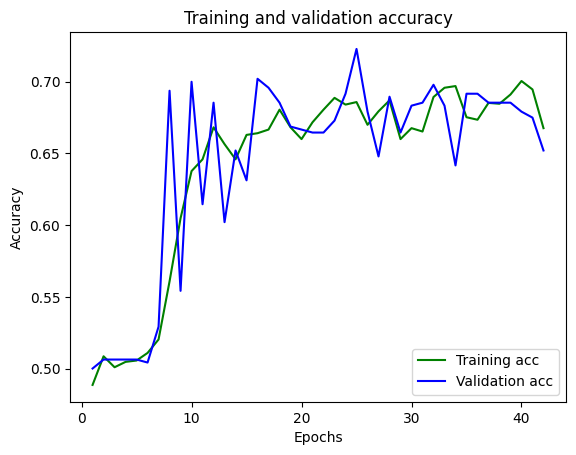

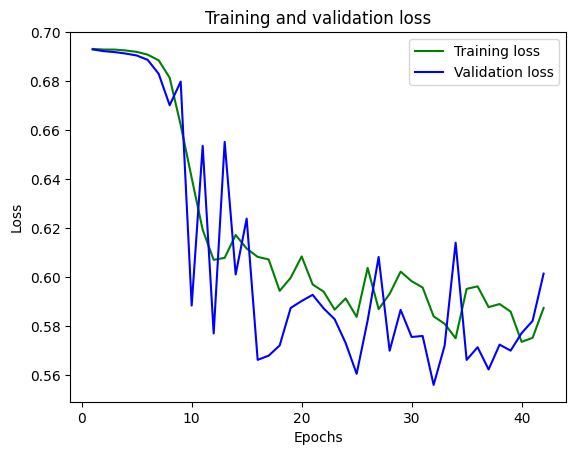

In [43]:
acc = hist['acc']
val_acc = hist['val_acc']
loss = hist['loss']
val_loss = hist['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [66]:
# Here we can see, train & validation data's acuuracy & loss aprroches to each other, and its having good accuracy (76 %)

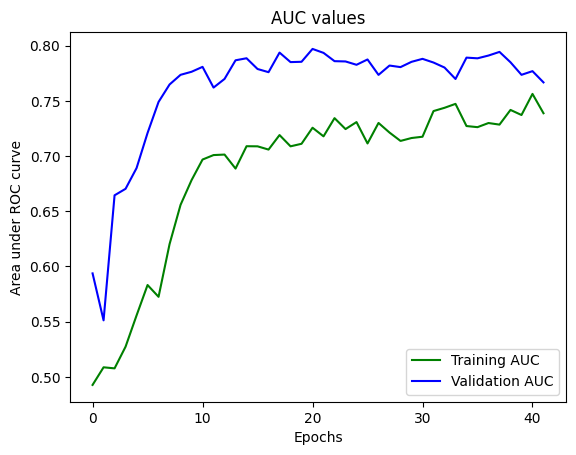

In [69]:
plt.plot(hist['auc'], 'g', label='Training AUC')
plt.plot(hist['val_auc'], 'b', label='Validation AUC')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Area under ROC curve")
plt.title("AUC values")
plt.show()

In [65]:
# Here, AUC value is closer to 75%

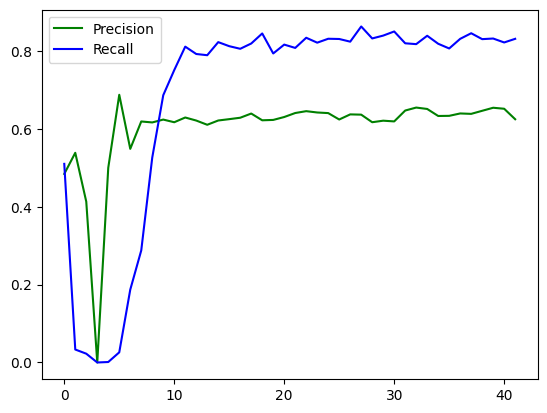

In [48]:
plt.plot(hist['precision'], 'g', label='Precision')
plt.plot(hist['recall'], 'b', label='Recall')
plt.legend()
plt.show()

In [64]:
# Here, precision is around 65% & recall is about 85%.
# It means the models have some chance of giving False positive (sloghtly low precision), 
# but it is less likely to return false negative (high recall), and maximum positive cases will be caught.

In [28]:
#saving the model for future reference
resnet_model.save("CovidPredict.h5")

In [29]:
##       PREDICTION  ##

# Loading the model
my_model=load_model('CovidPredict.h5')

In [30]:
#Generating our test data set
test_dir=curr+'/final/test'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='binary',
                                                   color_mode='grayscale')

Found 250 images belonging to 2 classes.


In [31]:
#evaluating model for test dataset for the metrics
loss,acc,pre,recall,auc=my_model.evaluate(test_generator, verbose=2)

8/8 - 4s - loss: 0.5822 - acc: 0.6880 - precision: 0.6198 - recall: 0.9597 - auc: 0.7843 - 4s/epoch - 474ms/step


In [67]:
# We can also use model.predict to get individual prediction
# this will return array of value between 0 to 1, & after defining a thresold(generally 0.5), we classify it.
predt=my_model.predict(test_generator)

8/8 [==============================] - 1s 101ms/step
